In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout,  Input
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/feature_engineered_aqi_data_local.csv")

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df = df.set_index('date').sort_index()

In [5]:
print("--- Data loaded and converted to time series ---")
print(df.head())
print("-" * 30)

--- Data loaded and converted to time series ---
                                 city  pm10  pm2_5  carbon_monoxide  \
date                                                                  
2023-06-01 06:00:00+00:00       dhaka  51.3   34.1            369.0   
2023-06-01 06:00:00+00:00  chittagong  48.4   30.7            288.0   
2023-06-01 06:00:00+00:00      khulna  33.1   20.8            263.0   
2023-06-01 07:00:00+00:00       dhaka  50.2   32.5            381.0   
2023-06-01 07:00:00+00:00  chittagong  49.6   30.6            281.0   

                           nitrogen_dioxide  sulphur_dioxide  ozone  \
date                                                                  
2023-06-01 06:00:00+00:00              17.9              8.6   44.0   
2023-06-01 06:00:00+00:00               8.4              4.7   61.0   
2023-06-01 06:00:00+00:00               5.6              4.6   65.0   
2023-06-01 07:00:00+00:00              19.3             10.4   53.0   
2023-06-01 07:00:00+00:00  

In [6]:
le = LabelEncoder()
df['city_encoded'] = le.fit_transform(df['city'])

In [7]:
TARGET_COL = "us_aqi"

In [8]:
def r_squared(y_true, y_pred):
    """
    Calculates the R-squared (coefficient of determination) metric.
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

In [9]:
def build_mlp_lstm_model(input_shape):
    model = Sequential(name="MLP_LSTM_Hybrid_Model")
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Dense(10, activation='relu')))
    model.add(TimeDistributed(Dense(5, activation='relu')))
    model.add(TimeDistributed(Dense(1, activation='relu')))
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    return model

In [10]:
def calculate_permutation_importance(model, X_test, y_test, feature_names):
    """
    Calculates feature importance using the permutation method.
    """
    print("Calculating baseline performance...")
    # 1. Calculate baseline performance
    baseline_preds = model.predict(X_test, verbose=0).flatten()
    baseline_mae = mean_absolute_error(y_test, baseline_preds)
    print(f"Baseline Test MAE: {baseline_mae:.4f}")
    
    importances = {}
    
    # 2. Iterate through each feature
    for i, name in enumerate(feature_names):
        print(f"Shuffling feature: {name} ({i+1}/{len(feature_names)})...")
        
        X_test_permuted = X_test.copy()
        
        # Shuffle the i-th feature column
        np.random.shuffle(X_test_permuted[:, :, i])
        
        # 3. Make predictions with the permuted data
        permuted_preds = model.predict(X_test_permuted, verbose=0).flatten()
        
        # 4. Calculate the new MAE
        permuted_mae = mean_absolute_error(y_test, permuted_preds)
        
        # 5. Store the increase in error as the importance score
        importances[name] = permuted_mae - baseline_mae
        
    return importances

## Run 1

In [11]:
X = df[[col for col in df.columns if col not in ["city", TARGET_COL]]]
y = df[TARGET_COL]

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=43)

In [13]:
X.columns

Index(['pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'uv_index_clear_sky', 'uv_index', 'dust',
       'aerosol_optical_depth', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'day_of_week', 'year', 'city_encoded'],
      dtype='object')

In [15]:
test_df = pd.read_csv("datasets/feature_engineered_aqi_data_local_recent.csv")

In [16]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.set_index('date').sort_index()

In [17]:
le = LabelEncoder()
test_df['city_encoded'] = le.fit_transform(test_df['city'])

In [18]:
X_test = test_df[[col for col in test_df.columns if col not in ["us_aqi", "city"]]]
y_test = test_df["us_aqi"]

In [19]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (43833, 17)
y_train shape: (43833,)
X_val shape: (10959, 17)
y_val shape: (10959,)
X_test shape: (3744, 17)
y_test shape: (3744,)


In [20]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [22]:
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

X_train_reshaped shape: (43833, 1, 17)
X_val_reshaped shape: (10959, 1, 17)
X_test_reshaped shape: (3744, 1, 17)


In [23]:
n_features = X_train_reshaped.shape[2]
input_shape = (1, n_features)

In [24]:
model1 = build_mlp_lstm_model(input_shape=input_shape)
model1.compile(optimizer="adam", loss="mean_squared_error", metrics=[
        'mae',  # Built-in metric by string name
        tf.keras.metrics.MeanAbsolutePercentageError(name='mape'), # Metric as a class instance
        r_squared  # Custom metric function
    ])

In [25]:
print("--- Model Summary ---")
model1.summary()
print("-" * 30)

--- Model Summary ---


Model: "MLP_LSTM_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 10)          │           180 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 5)           │            55 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 1)           │             6 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,802 (311.73 KB)

 Trainable params: 79,802 (311.73 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------


In [26]:
print("--- Starting Model Training ---")
history1 = model1.fit(
    X_train_reshaped,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
print("--- Model Training Finished ---")
print("-" * 30)

--- Starting Model Training ---
Epoch 1/50
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1257.7688 - mae: 22.4705 - mape: 27.1053 - r_squared: 0.4129 - val_loss: 358.9682 - val_mae: 14.7309 - val_mape: 18.5743 - val_r_squared: 0.8345
Epoch 2/50
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 346.1999 - mae: 14.2910 - mape: 17.6657 - r_squared: 0.8376 - val_loss: 320.1520 - val_mae: 13.7534 - val_mape: 16.7312 - val_r_squared: 0.8520
Epoch 3/50
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 317.2523 - mae: 13.5436 - mape: 16.4821 - r_squared: 0.8509 - val_loss: 304.2972 - val_mae: 13.3574 - val_mape: 16.5331 - val_r_squared: 0.8585
Epoch 4/50
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 296.6829 - mae: 13.0087 - mape: 15.7699 - r_squared: 0.8604 - val_loss: 305.3933 - val_mae: 13.3743 - val_mape: 16.9113 - val_r_squared: 0.8576
Epoch 5/50
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 287.1032 - mae: 12.7609 - mape: 15.4879 - r_squared: 0.8642 - val_loss: 281.6031 

In [27]:
print("--- Evaluating Model on Test Set ---")
results = model1.evaluate(X_test_reshaped, y_test, verbose=1)
results = [round(result, 2) for result in results]
print(f"Test Loss (MSE): {results[0]}")
print(f"Test Mean Absolute Error (MAE): {results[1]}")
print(f"Test Mean Absolute Percentage Error (MAPE): {results[2]} %")
print(f"Test R-squared: {results[3]}")
print("-" * 30)

--- Evaluating Model on Test Set ---
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134.1439 - mae: 8.8059 - mape: 16.9741 - r_squared: -1.0534
Test Loss (MSE): 134.14
Test Mean Absolute Error (MAE): 8.81
Test Mean Absolute Percentage Error (MAPE): 16.97 %
Test R-squared: -1.05
------------------------------


In [24]:
print("--- Making a Prediction on the First Test Sample ---")
prediction = model1.predict(X_test_reshaped[:1])
actual_value = y_test.iloc[0] if isinstance(y_test, pd.Series) else y_test[0]
print(f"Predicted AQI: {prediction[0][0]:.2f}")
print(f"Actual AQI: {actual_value:.2f}")
print("-" * 30)

--- Making a Prediction on the First Test Sample ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted AQI: 162.22
Actual AQI: 158.73
------------------------------


--- Plotting Training History for All Metrics ---


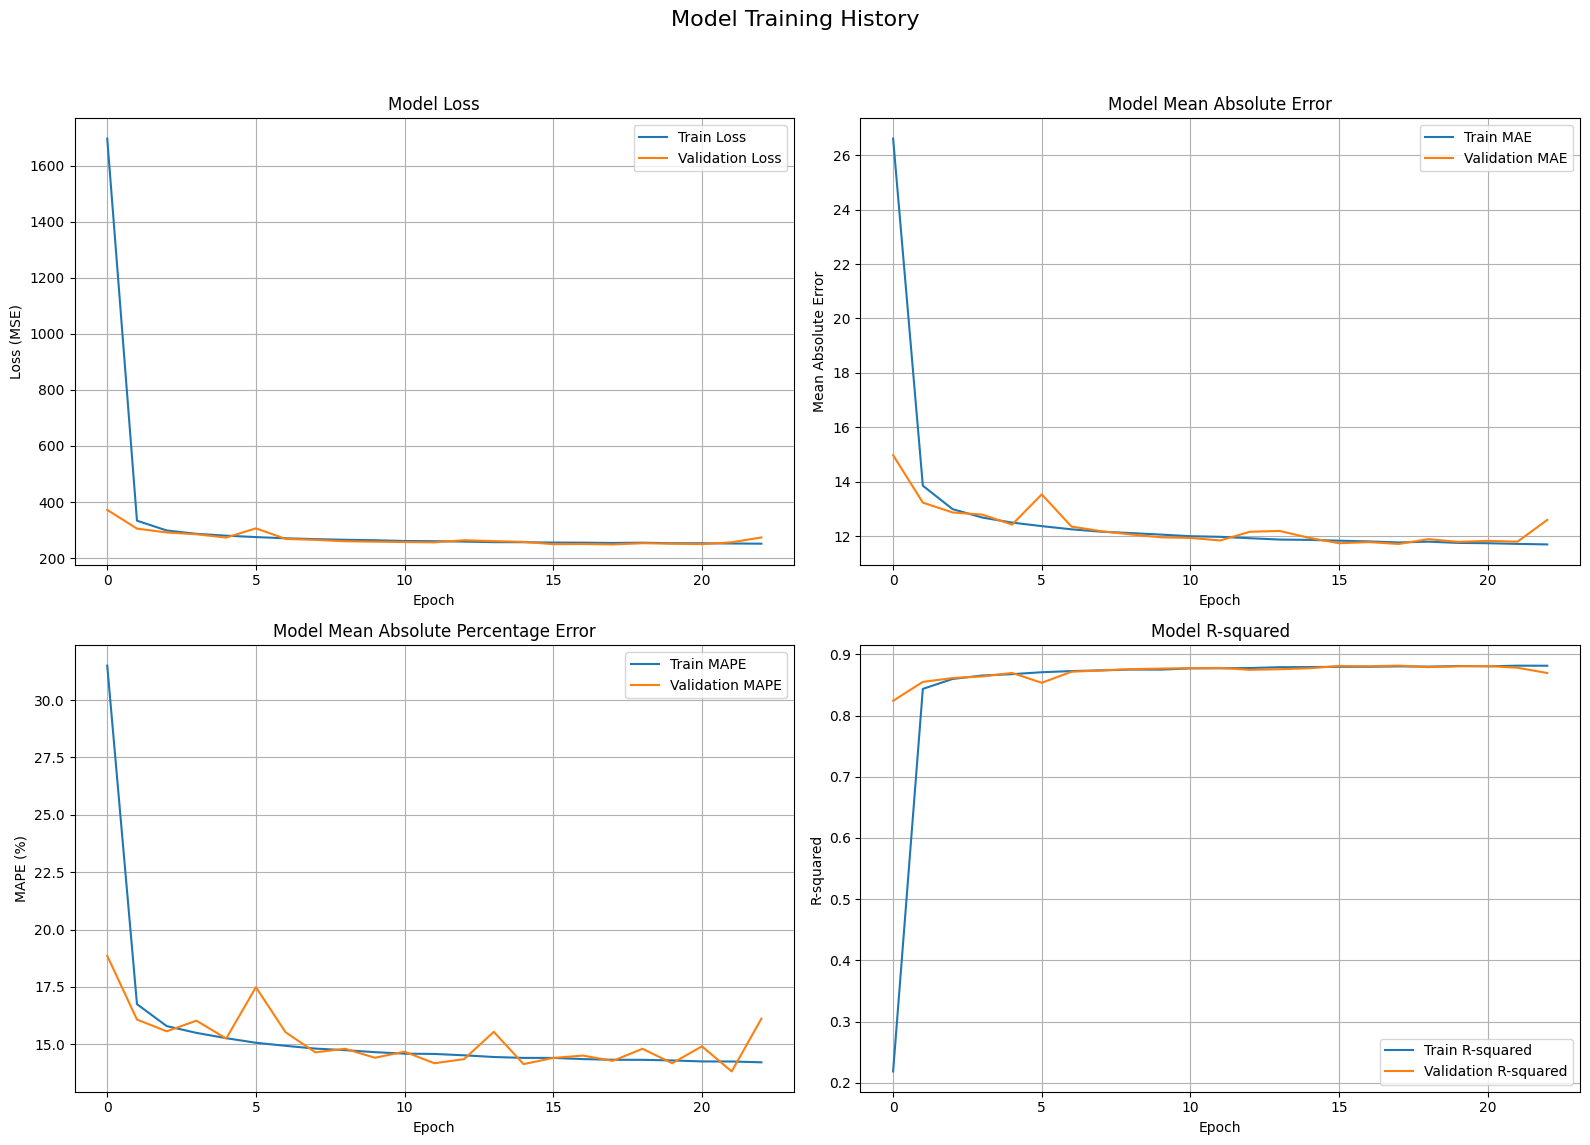

In [25]:
print("--- Plotting Training History for All Metrics ---")

# Create a figure with a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Training History', fontsize=16)

# --- Plot 1: Model Loss (MSE) ---
ax[0, 0].plot(history1.history['loss'], label='Train Loss')
ax[0, 0].plot(history1.history['val_loss'], label='Validation Loss')
ax[0, 0].set_title('Model Loss')
ax[0, 0].set_ylabel('Loss (MSE)')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].legend(loc='upper right')
ax[0, 0].grid(True)

# --- Plot 2: Mean Absolute Error (MAE) ---
ax[0, 1].plot(history1.history['mae'], label='Train MAE')
ax[0, 1].plot(history1.history['val_mae'], label='Validation MAE')
ax[0, 1].set_title('Model Mean Absolute Error')
ax[0, 1].set_ylabel('Mean Absolute Error')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].legend(loc='upper right')
ax[0, 1].grid(True)

# --- Plot 3: Mean Absolute Percentage Error (MAPE) ---
# Note: The key might be 'mean_absolute_percentage_error' or 'mape'
# depending on your TensorFlow version. Check history.history.keys() if you get an error.
mape_key = 'mape' if 'mape' in history1.history else 'mean_absolute_percentage_error'
val_mape_key = 'val_mape' if 'val_mape' in history1.history else 'val_mean_absolute_percentage_error'

ax[1, 0].plot(history1.history[mape_key], label='Train MAPE')
ax[1, 0].plot(history1.history[val_mape_key], label='Validation MAPE')
ax[1, 0].set_title('Model Mean Absolute Percentage Error')
ax[1, 0].set_ylabel('MAPE (%)')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].legend(loc='upper right')
ax[1, 0].grid(True)

# --- Plot 4: R-squared ---
ax[1, 1].plot(history1.history['r_squared'], label='Train R-squared')
ax[1, 1].plot(history1.history['val_r_squared'], label='Validation R-squared')
ax[1, 1].set_title('Model R-squared')
ax[1, 1].set_ylabel('R-squared')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].legend(loc='lower right') # Lower right is often better for R²
ax[1, 1].grid(True)

# Adjust layout to prevent plots from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
--- Plotting Actual vs. Predicted Values ---


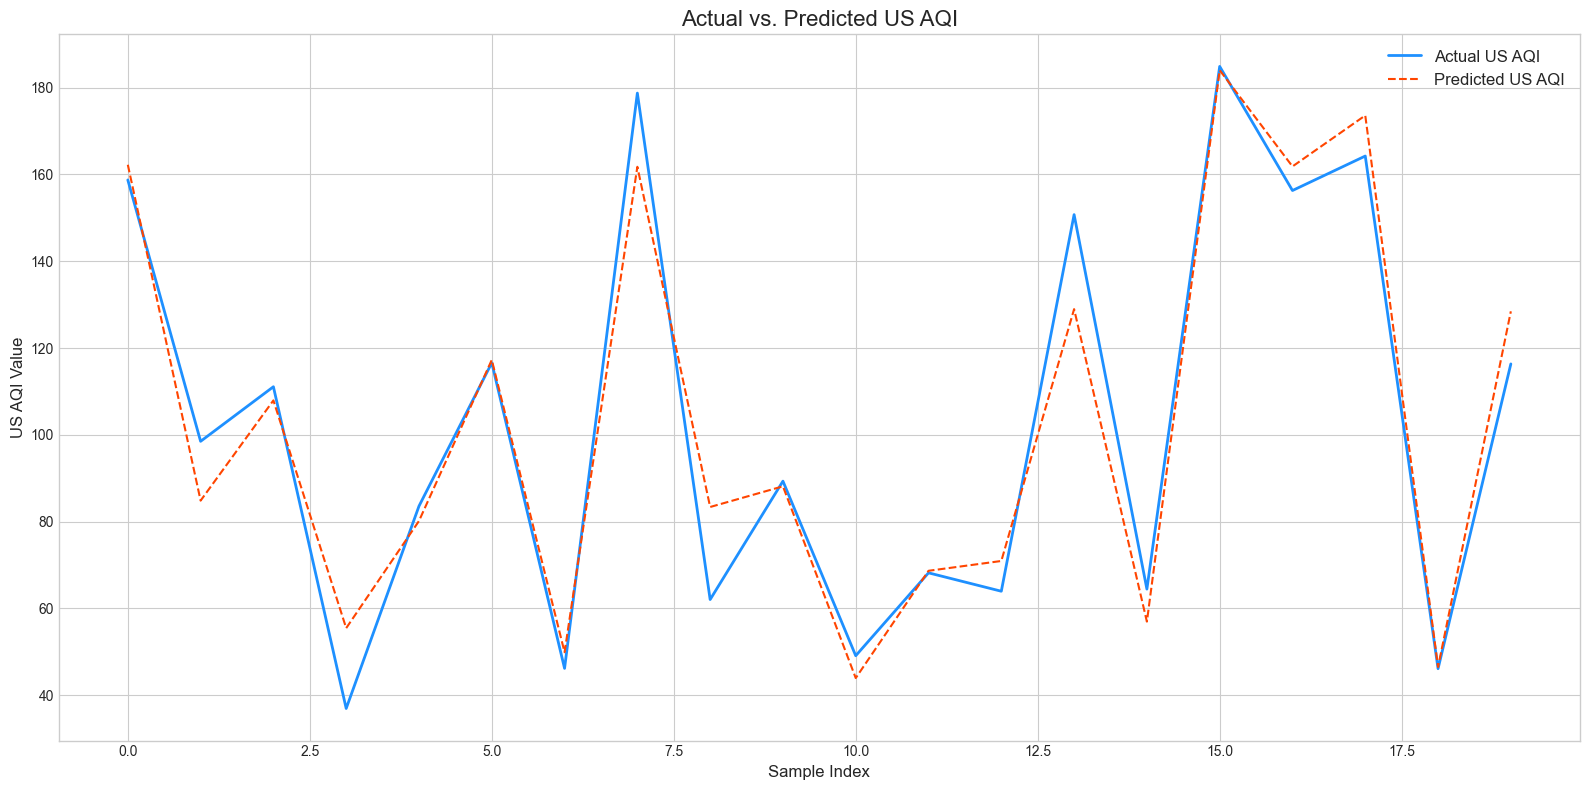

In [26]:
import seaborn as sns
y_pred = model1.predict(X_test_reshaped).flatten()
print("--- Plotting Actual vs. Predicted Values ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

sample_size = 20
actual_sample = y_test.iloc[:sample_size].values
predicted_sample = y_pred[:sample_size]

plt.plot(actual_sample, label='Actual US AQI', color='dodgerblue', linewidth=2)
plt.plot(predicted_sample, label='Predicted US AQI', color='orangered', linestyle='--')

plt.title(f'Actual vs. Predicted US AQI', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('US AQI Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# RECENT DATA

In [44]:
test_df = pd.read_csv("datasets/feature_engineered_aqi_data_local_recent.csv")

In [45]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.set_index('date').sort_index()

In [46]:
le = LabelEncoder()
test_df['city_encoded'] = le.fit_transform(test_df['city'])

In [47]:
X_recent = test_df[[col for col in test_df.columns if col not in ["us_aqi", "city"]]]
y_recent = test_df["us_aqi"]

In [48]:
X_scaled_recent = scaler.transform(X_recent)

In [49]:
X_reshaped_recent = X_scaled_recent.reshape((X_scaled_recent.shape[0], 1, X_scaled_recent.shape[1]))

print(f"Shape of recent data for prediction: {X_reshaped_recent.shape}")
print("-" * 30)

Shape of recent data for prediction: (3744, 1, 17)
------------------------------


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
--- Plotting Actual vs. Predicted Values (Recent Data) ---


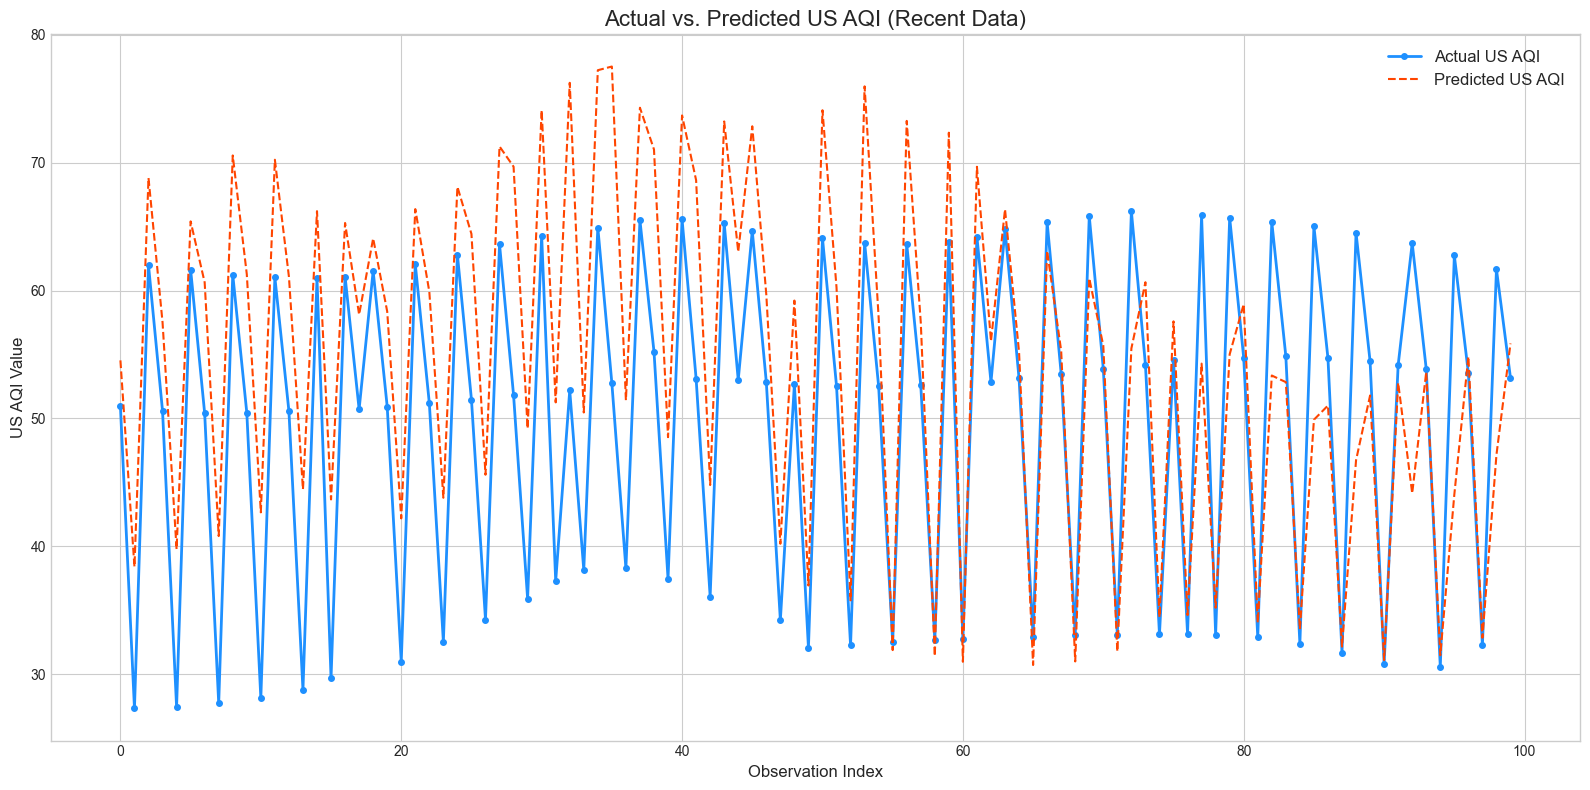

In [52]:
y_pred_recent = model1.predict(X_reshaped_recent).flatten() # Use .flatten() to make it a 1D array for plotting

# --- Plot Actual vs. Predicted Values for Recent Data ---
print("--- Plotting Actual vs. Predicted Values (Recent Data) ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

# You can adjust sample_size if you have a lot of data
sample_size = 100 
actual_sample = y_recent.iloc[:sample_size].values
predicted_sample = y_pred_recent[:sample_size]

plt.plot(actual_sample, label='Actual US AQI', color='dodgerblue', linewidth=2, marker='o', markersize=4)
plt.plot(predicted_sample, label='Predicted US AQI', color='orangered', linestyle='--')

plt.title('Actual vs. Predicted US AQI (Recent Data)', fontsize=16)
plt.xlabel('Observation Index', fontsize=12)
plt.ylabel('US AQI Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
print("--- Evaluating Model on Recent Data ---")
results_recent = model1.evaluate(X_reshaped_recent, y_recent, verbose=1)
results_recent = [round(result, 2) for result in results_recent]
print(f"Recent Data - Test Loss (MSE): {results_recent[0]}")
print(f"Recent Data - Test Mean Absolute Error (MAE): {results_recent[1]}")
print(f"Recent Data - Test Mean Absolute Percentage Error (MAPE): {results_recent[2]} %")
print(f"Recent Data - Test R-squared: {results_recent[3]}")
print("-" * 30)

--- Evaluating Model on Recent Data ---
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.7571 - mae: 8.9599 - mape: 17.2982 - r_squared: -0.8105
Recent Data - Test Loss (MSE): 138.76
Recent Data - Test Mean Absolute Error (MAE): 8.96
Recent Data - Test Mean Absolute Percentage Error (MAPE): 17.3 %
Recent Data - Test R-squared: -0.81
------------------------------
